First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
# 1. abundance matrix--> relative abundance matrix
data=FS.relative_abundance(data)
print(np.shape(data))

(59, 1768)


In [6]:
data

array([[0.01578653, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01691234, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [7]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [47]:
print(yList[:5])
      
for i in range(yList.shape[1]):
    print(pd.Series(yList[:,i]).value_counts())

[['No' 'Natural' 'Annual']
 ['No' 'Natural' 'Perennial']
 ['No' 'Urban' 'Perennial']
 ['No' 'Urban' 'Annual']
 ['No' 'Urban' 'Perennial']]
Yes    42
No     17
Name: count, dtype: int64
Urban      33
Natural    26
Name: count, dtype: int64
Perennial    37
Annual       22
Name: count, dtype: int64


In [9]:
yList[:,1]

array(['Natural', 'Natural', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban',
       'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban',
       'Natural', 'Natural', 'Natural', 'Urban', 'Urban', 'Urban',
       'Natural', 'Natural', 'Natural', 'Natural', 'Natural', 'Natural',
       'Natural', 'Urban', 'Urban', 'Urban', 'Urban', 'Natural',
       'Natural', 'Natural', 'Natural', 'Natural', 'Urban', 'Urban',
       'Urban', 'Urban', 'Natural', 'Natural', 'Natural', 'Natural',
       'Natural', 'Natural', 'Natural', 'Natural', 'Natural', 'Urban',
       'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban',
       'Urban', 'Urban'], dtype=object)

In [10]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

In [12]:
weights=FS.OTU_H_Score_fun(data,yList)

In [13]:
weights

array([[3.58783345, 4.62436719, 5.89262923, ..., 0.        , 0.        ,
        0.        ],
       [2.4157006 , 1.16409551, 2.79448091, ..., 0.        , 0.        ,
        0.        ],
       [0.1986735 , 0.57734704, 3.25951225, ..., 0.        , 0.        ,
        0.        ]])

In [14]:
print(weights.ndim)
print(weights.shape)# each row is a H score for each response variable

2
(3, 1768)


In [15]:
#check  the H statistics
df1 = pd.DataFrame(weights, index=['burn_label', 'un_label', 'duration_label'])
columns_sig = (df1 > 2.705543454095404).any()
# Count the number of columns where at least one value is larger than 0
count = columns_sig.sum()
print(count)
count_larger= (df1 > 2.705543454095404).sum(axis=1)

# Display the result
print("Number of values larger than significance cutoff in each row:")
print(count_larger)

86
Number of values larger than significance cutoff in each row:
burn_label        56
un_label          29
duration_label    19
dtype: int64


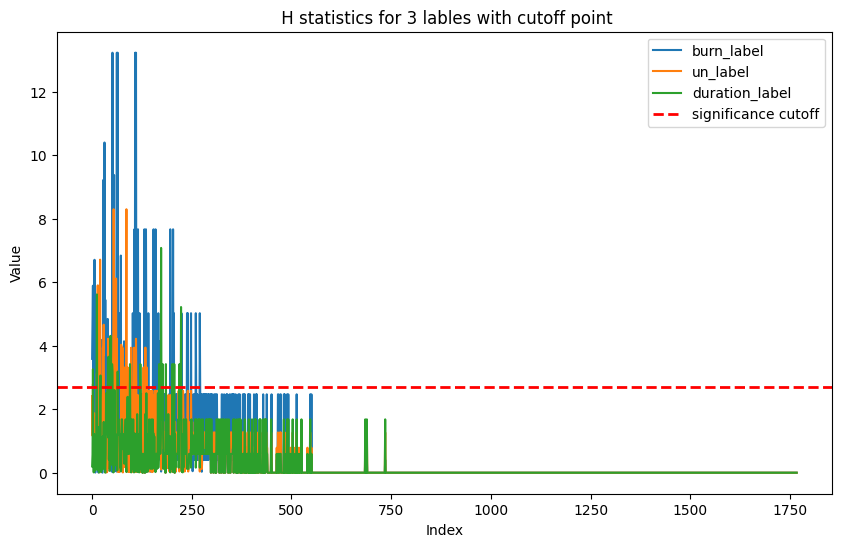

In [16]:
import matplotlib.pyplot as plt
# Plotting each row individually
# Plotting each row individually
plt.figure(figsize=(10, 6))
for row in df1.index:
    plt.plot(df1.columns, df1.loc[row], label=row)

# Add a horizontal line at y=0
plt.axhline(y=2.705543454095404, color='red', linestyle='--', linewidth=2, label='significance cutoff')

# Set plot title and labels
plt.title(' H statistics for 3 lables with cutoff point')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 3. Select OTUs

In [17]:
# select the OTUs
selectedOTU_index_list = []
eps_list = []
for i in range(yList.shape[1]):
    selectedOTU_index, eps=FS.indice_H_unisig(weights[i,:],yList[:,i])
    selectedOTU_index_list.append(selectedOTU_index)
    eps_list.append(eps)

In [18]:
eps_list

[56, 29, 19]

### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [19]:
iter =30
cls = ["RF","SVM"]

In [20]:
X_lasso_list = []
X_lassoft_list =[]
selectedOTU_index_lasso_list = []
selectedOTU_index_lassoft_list = []

dict_cm_list = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = data[:,selectedOTU_index_list[i]]
    
    X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
    X_lasso_list.append(X_lasso)
    selectedOTU_index_lasso_list.append(xlabel_lasso)

    X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lassoft_list.append(X_lasso_ft)
    selectedOTU_index_lassoft_list.append(xlabel_lasso_ft)
    
    
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft,
               "Random":data
              }
    print(f'The shape of the original dataset is ',np.shape(data))
    print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
    print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))

    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    dict_cm_list.append(dict_cm)

  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the Lasso selected dataset is  (59, 21)
The shape of the Lasso_finetune selected dataset is  (59, 14)
                RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures        0.763636  0.916898      0.712121  0.865046
SelectMicro        0.863636  0.971528      0.712121  0.962269
Lasso              0.880303  1.000000      0.712121  0.944444
Lasso_finetune     0.913636  1.000000      0.712121  0.944444
Random             0.662121  0.636304      0.493788  0.349761
The response variable and its counts are:
Urban      33
Natural    26
Name: count, dtype: int64
Best alpha: 0.1
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 29)
The shape of the Lasso selected dataset is  (59, 58)
The shape of the Lasso_finetune selected datas

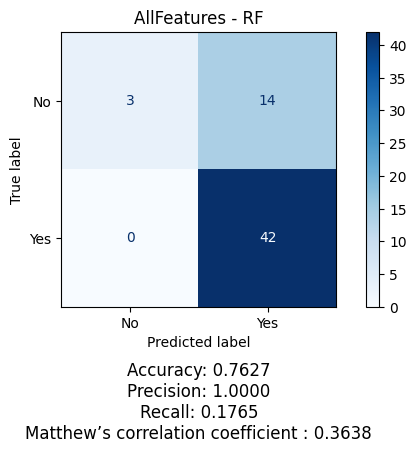

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


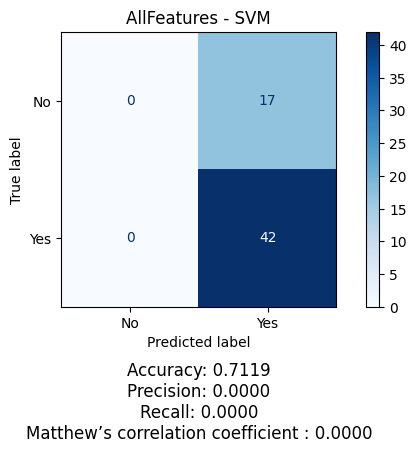

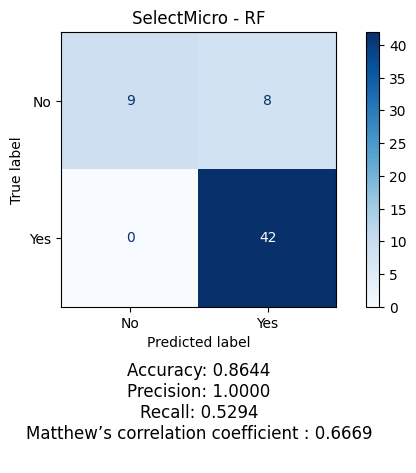

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


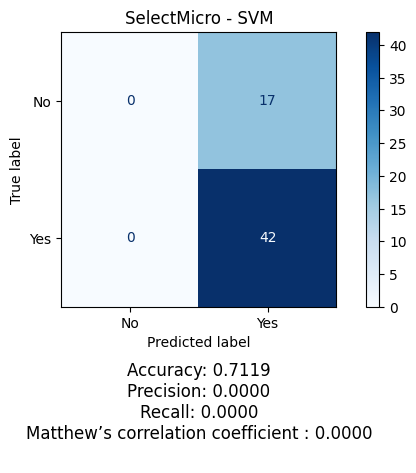

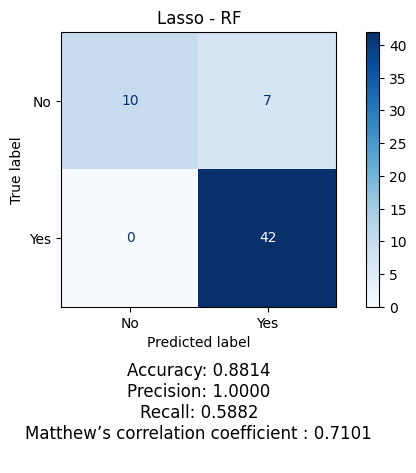

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


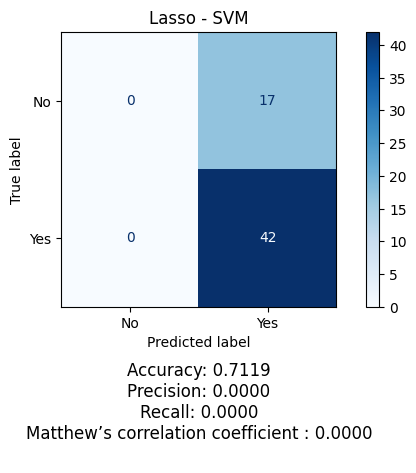

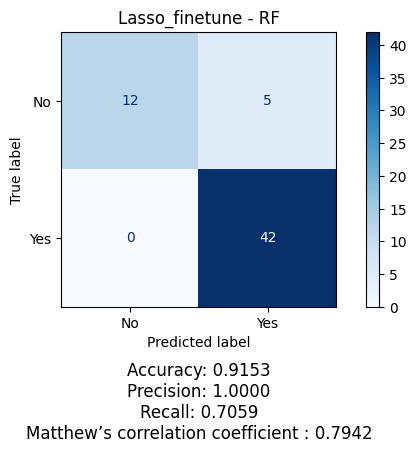

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


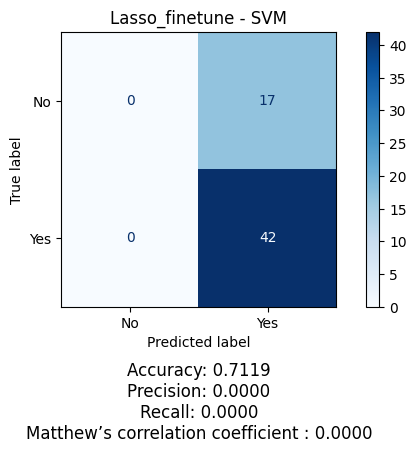

In [21]:
dict_cm = dict_cm_list[0]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

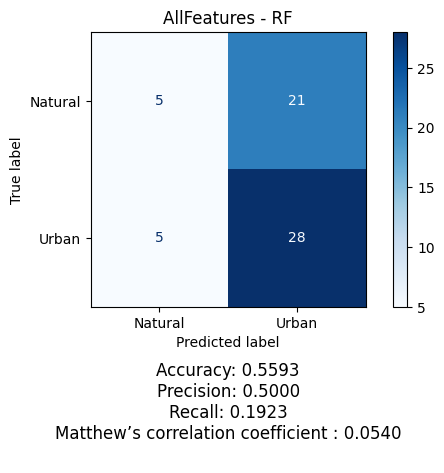

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


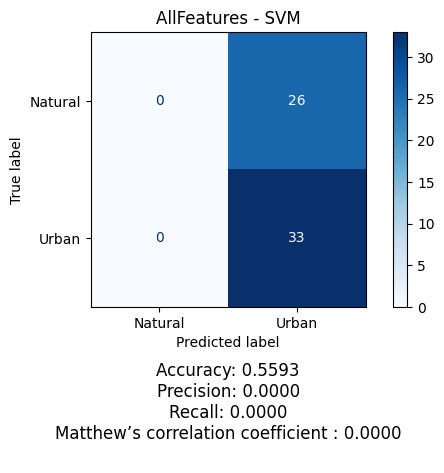

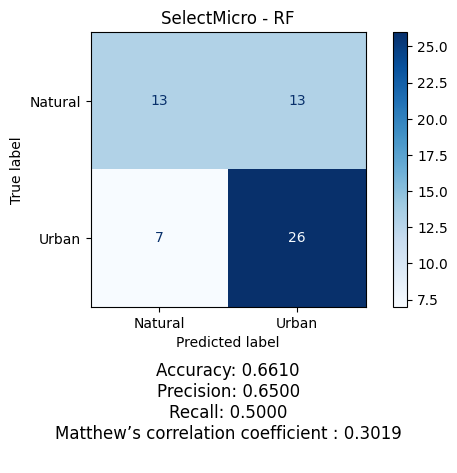

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


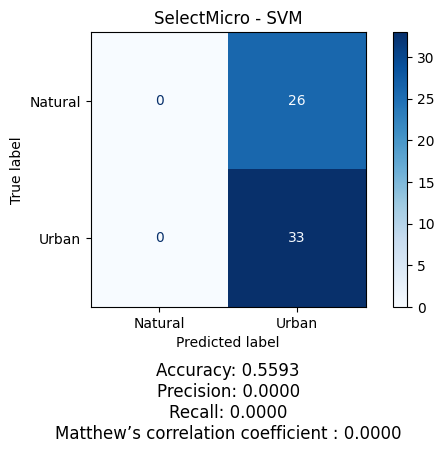

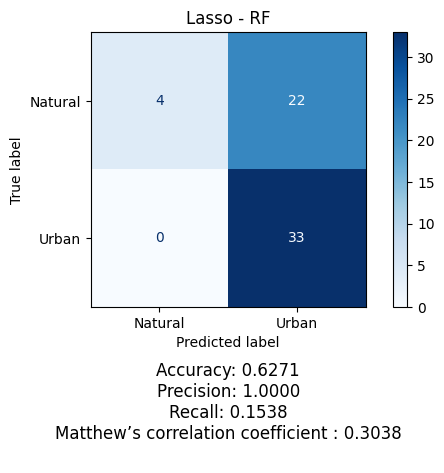

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


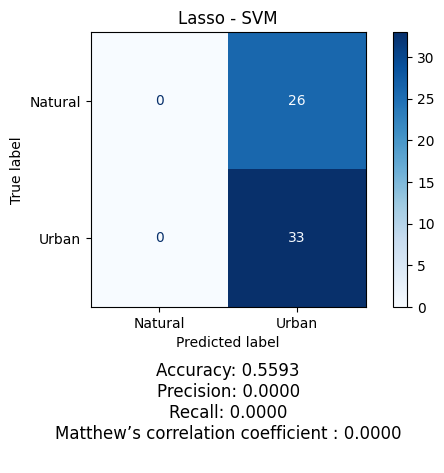

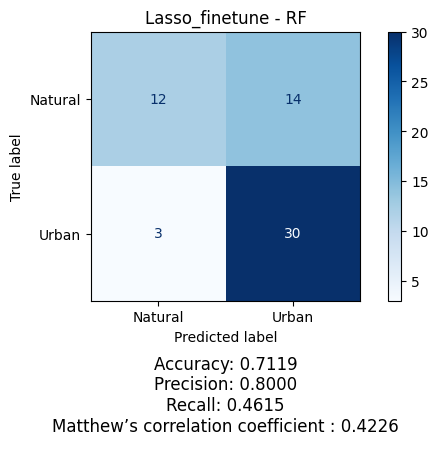

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


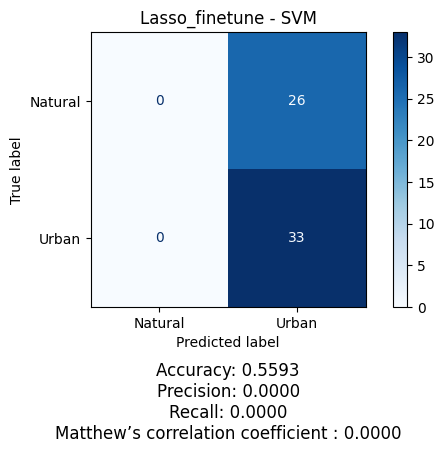

In [22]:

dict_cm = dict_cm_list[1]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

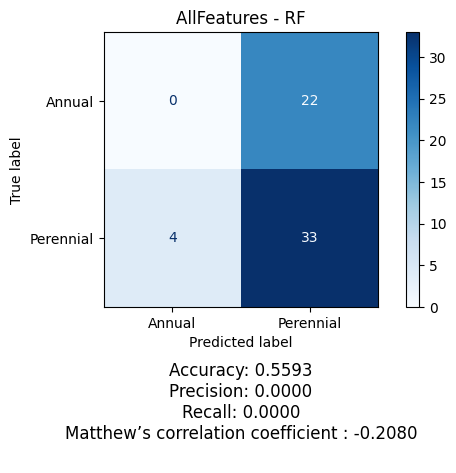

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


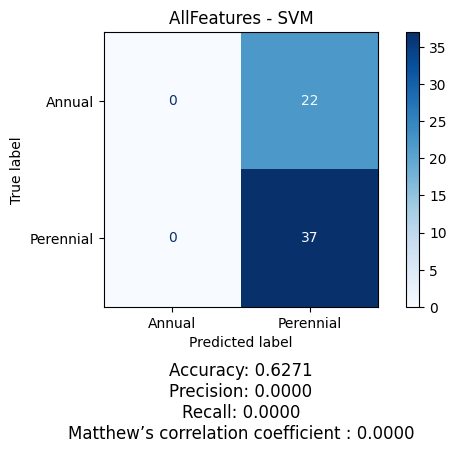

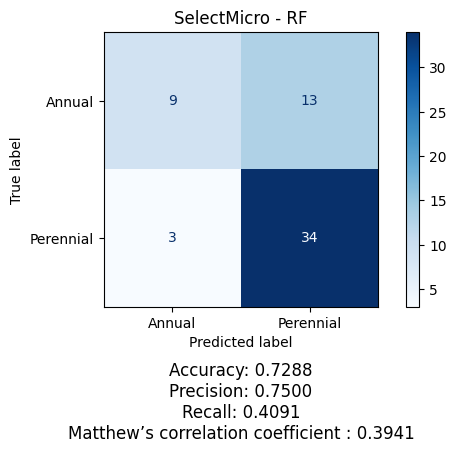

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


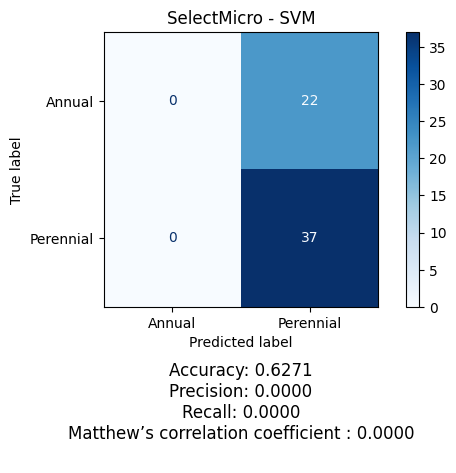

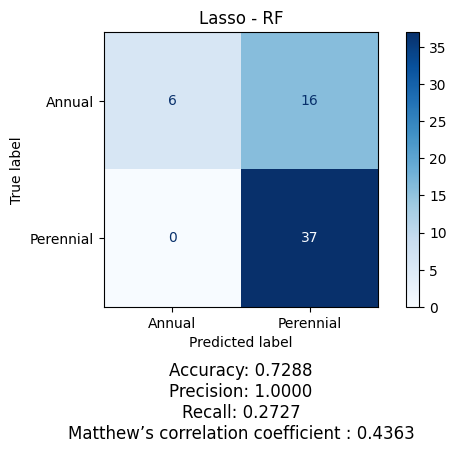

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


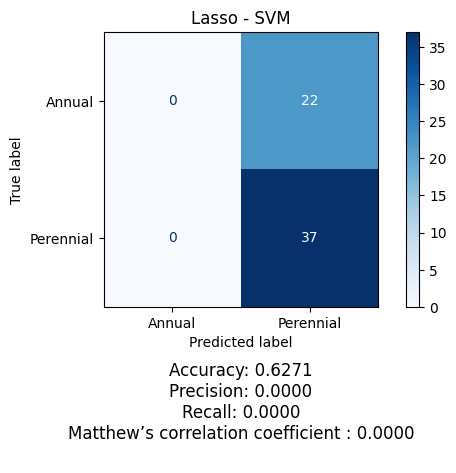

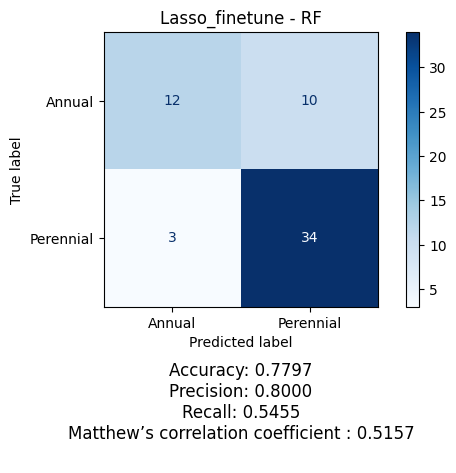

/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


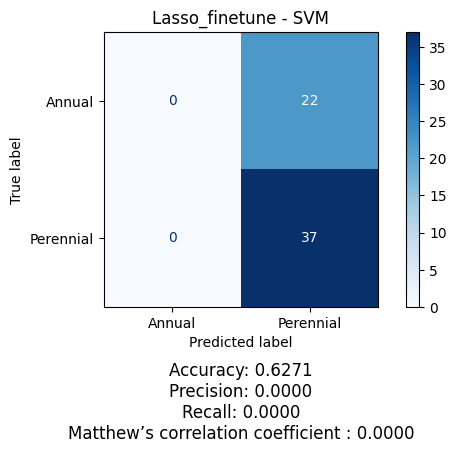

In [23]:
dict_cm = dict_cm_list[2]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

### 5. Use Leave one out Crossvalidation for fine tune the model's parameter and also the model's prediction

In [42]:
from sklearn.model_selection import LeaveOneOut
from imblearn.over_sampling import SMOTE
def nested_loocv(X, y,classifier="SVM", smote=False):
    """
    Perform nested leave-one-out cross-validation. (loocv in parameter tuninng - inner and then loocv in testing - outer)
    suitable for small datasets like smoky data

    Parameters:
        X: ndarray
            Features.
        y: ndarray
            Labels.
        param_grid: dict
            Hyperparameter grid for tuning.
        classifier: str
            "SVM" or "RF" (Random Forest).
        smote: bool
            Whether to apply SMOTE to the training data.

    Returns:
        dict:
            Contains mean accuracy, mean AUC, and the list of metrics for each outer fold.
    """
    outer_loocv = LeaveOneOut()
    inner_loocv = LeaveOneOut()

    # Metrics to store results
    outer_accuracies = []
    #outer_aucs = []

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_index, test_index in outer_loocv.split(X):
        # Outer split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE to the training data in the outer loop
        if smote:
            sm = SMOTE(random_state=777)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # Define the classifier
        if classifier == "SVM":
            model = svm.SVC(probability=True, random_state=777)
            model_param_grid = {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf', 'linear'],
                'probability': [True]
            }
        elif classifier == "RF":
            model = RandomForestClassifier(random_state=777)
            model_param_grid = {
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion' :['gini', 'entropy'],
        }
        else:
            raise ValueError("Classifier must be 'SVM' or 'RF'.")

        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=model_param_grid,
            cv=inner_loocv,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate on the outer test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        #auc = roc_auc_score(y_test, y_prob)# not applicable since there is only one sample in the testing for LOOCV

        # Store results
        outer_accuracies.append(accuracy)
        #outer_aucs.append(auc)

        #To append the actual value (not a 1-element array), you access the first (and only) element with [0]
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])
        y_prob_all.append(y_prob[0])

    # Calculate mean metrics
    mean_accuracy = sum(outer_accuracies) / len(outer_accuracies)
    #mean_auc = sum(outer_aucs) / len(outer_aucs)

    return {
        "mean_accuracy": mean_accuracy,
        #"mean_auc": mean_auc,
        "outer_accuracies": outer_accuracies,
        #"outer_aucs": outer_aucs,
        "y_true": y_true_all,
        "y_pred": y_pred_all,
        "y_prob": y_prob_all,
    }

In [44]:
# test LOO on SelectMicro using Y0
result_testloo = nested_loocv(data_subset['SelectMicro'],yList[:,0],smote=True)

Mean Accuracy: 0.8983050847457628
Std Accuracy: 0.30224668644283065


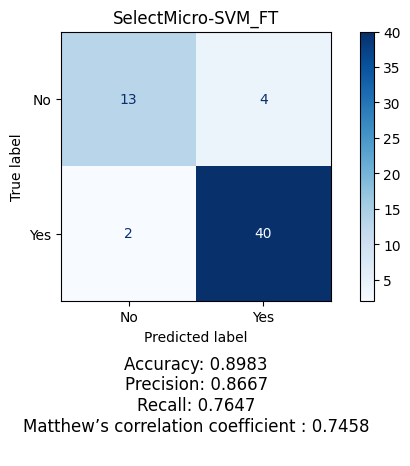

In [53]:
print("Mean Accuracy:", result_testloo["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo["y_true"], result_testloo["y_pred"],"SelectMicro-SVM_FT",pos_y=1)

In [54]:
# test LOO on Lasso_ft using Y0
result_testloo_la = nested_loocv(data_subset['Lasso_finetune'],yList[:,0],smote=True)

Mean Accuracy: 0.9152542372881356
Std Accuracy: 0.27850299534160994


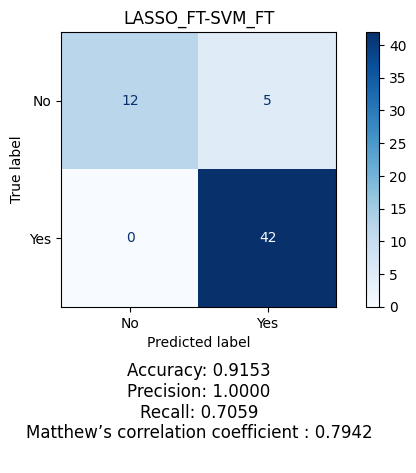

Mean Accuracy: 0.9661016949152542
Std Accuracy: 0.1809674280005307


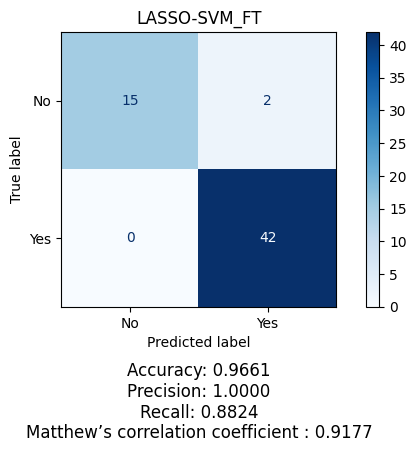

In [66]:
print("Mean Accuracy:", result_testloo_la["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo_la["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo_la["y_true"], result_testloo_la["y_pred"],title='LASSO_FT-SVM_FT',pos_y=1)


# test LOO on Lasso using Y0
result_testloo_l = nested_loocv(data_subset['Lasso'],yList[:,0],smote=True)

print("Mean Accuracy:", result_testloo_l["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo_l["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo_l["y_true"], result_testloo_l["y_pred"],title='LASSO-SVM_FT',pos_y=1)



## compare the first 20 index

In [58]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=[arr[:entries] for arr in selectedOTU_index_list]

selectedASVs_list = []
for i in range(yList.shape[1]):
    selectedASVs = ASVs[selectedOTU_index_15_list[i]]
    selectedASVs_list.append(selectedASVs)

Validation passed: Dimensions are correct.
42 17
       OTU  presence_pos  presence_neg
0    ASV66      0.000000      0.294118
1    ASV81      0.000000      0.294118
2    ASV85      0.000000      0.294118
3   ASV141      0.000000      0.294118
4   ASV148      0.000000      0.294118
5    ASV43      0.000000      0.235294
6    ASV73      0.023810      0.294118
7    ASV38      0.047619      0.352941
8   ASV139      0.000000      0.176471
9   ASV154      0.000000      0.176471
10  ASV174      0.000000      0.176471
11  ASV181      0.000000      0.176471
12  ASV208      0.000000      0.176471
13  ASV216      0.000000      0.176471
14  ASV263      0.000000      0.176471
15  ASV272      0.000000      0.176471
16   ASV94      0.023810      0.235294
17    ASV7      0.452381      0.117647
18    ASV3      0.285714      0.000000
19   ASV19      0.285714      0.000000


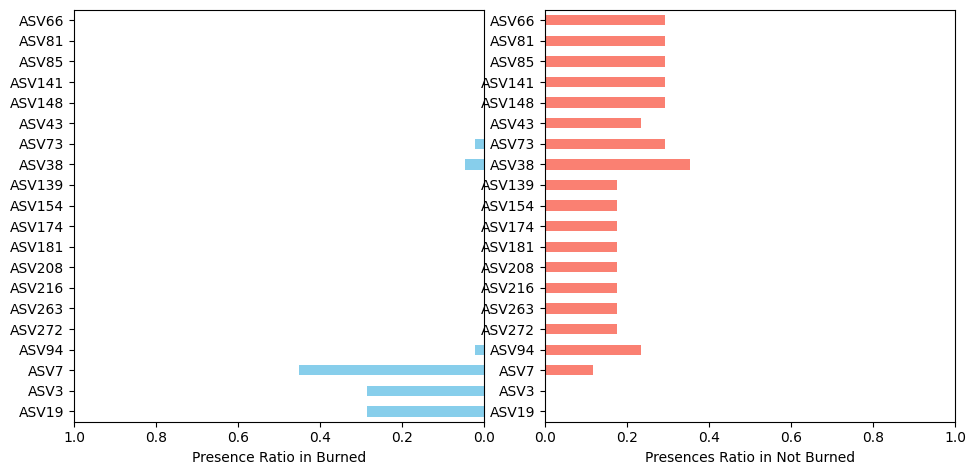

Validation passed: Dimensions are correct.
42 17
       OTU  presence_pos  presence_neg
0     ASV7      0.452381      0.117647
1     ASV8      0.119048      0.294118
2    ASV81      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV94      0.023810      0.235294
5   ASV141      0.000000      0.294118
6   ASV146      0.000000      0.117647
7   ASV148      0.000000      0.294118
8   ASV208      0.000000      0.176471
9   ASV216      0.000000      0.176471
10  ASV225      0.000000      0.117647
11  ASV315      0.000000      0.117647
12  ASV335      0.000000      0.117647
13  ASV338      0.000000      0.117647


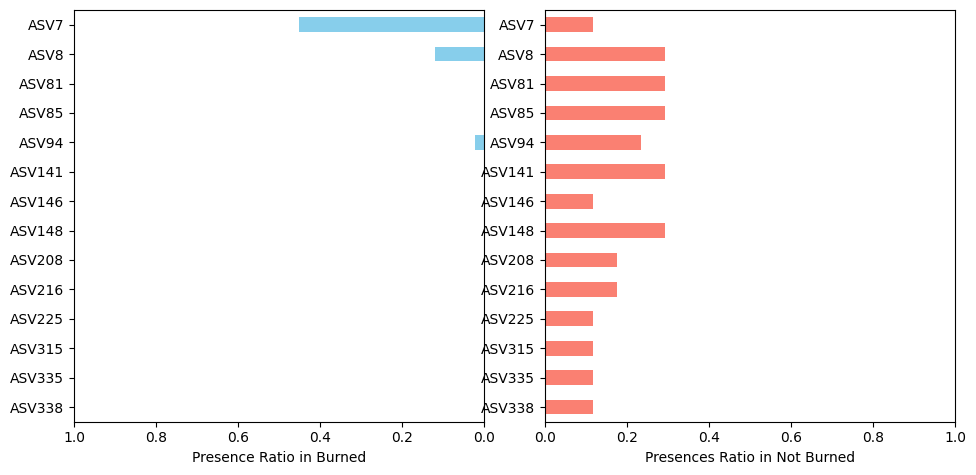

In [60]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[0]],yList[:,0],selectedASVs_list[0],
                     posLabel="Yes",posText="Burned",negText="Not Burned")
FS.plotPresenseRatio(X_lassoft_list[0],yList[:,0],ASVs[selectedOTU_index_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")



Validation passed: Dimensions are correct.
26 33
       OTU  presence_pos  presence_neg
0    ASV72      0.230769      0.000000
1   ASV111      0.230769      0.000000
2    ASV26      0.269231      0.030303
3    ASV79      0.000000      0.212121
4    ASV18      0.307692      0.060606
5    ASV73      0.000000      0.181818
6    ASV39      0.269231      0.060606
7    ASV52      0.000000      0.151515
8    ASV81      0.000000      0.151515
9   ASV148      0.000000      0.151515
10   ASV95      0.192308      0.030303
11   ASV37      0.115385      0.000000
12   ASV70      0.115385      0.000000
13   ASV99      0.115385      0.000000
14  ASV129      0.115385      0.000000
15  ASV138      0.115385      0.000000
16  ASV179      0.115385      0.000000
17  ASV180      0.115385      0.000000
18   ASV38      0.038462      0.212121
19  ASV104      0.000000      0.121212


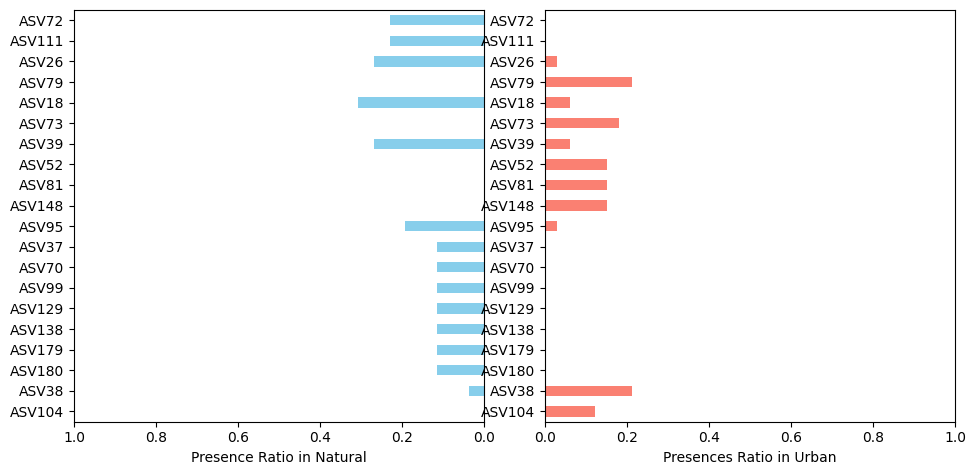

Validation passed: Dimensions are correct.
26 33
       OTU  presence_pos  presence_neg
0    ASV18      0.307692      0.060606
1    ASV52      0.000000      0.151515
2    ASV76      0.115385      0.060606
3    ASV79      0.000000      0.212121
4    ASV81      0.000000      0.151515
5    ASV95      0.192308      0.030303
6   ASV111      0.230769      0.000000
7   ASV114      0.000000      0.121212
8   ASV138      0.115385      0.000000
9   ASV179      0.115385      0.000000
10  ASV225      0.076923      0.000000


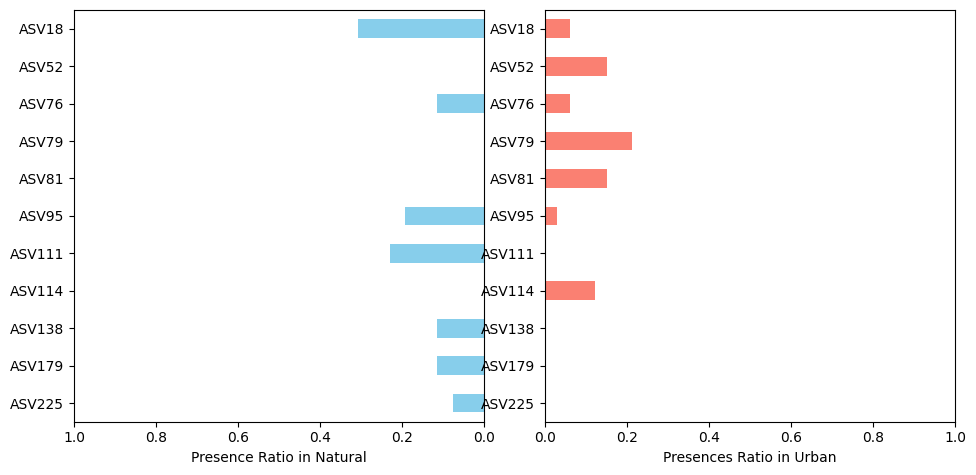

In [62]:
targetLabel=un_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[1]],yList[:,1],selectedASVs_list[1],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lassoft_list[1],yList[:,1],ASVs[selectedOTU_index_lassoft_list[1]],
                    posLabel="Natural",posText="Natural",negText="Urban")


Validation passed: Dimensions are correct.
22 37
       OTU  presence_pos  presence_neg
0   ASV237      0.181818      0.000000
1    ASV15      0.272727      0.054054
2   ASV310      0.136364      0.000000
3    ASV61      0.181818      0.027027
4    ASV53      0.227273      0.054054
5    ASV65      0.090909      0.000000
6   ASV122      0.090909      0.000000
7   ASV161      0.090909      0.000000
8   ASV227      0.090909      0.000000
9   ASV241      0.090909      0.000000
10  ASV250      0.090909      0.000000
11  ASV270      0.090909      0.000000
12  ASV271      0.090909      0.000000
13  ASV276      0.090909      0.000000
14  ASV304      0.090909      0.000000
15    ASV3      0.318182      0.135135
16   ASV66      0.000000      0.135135
17   ASV85      0.000000      0.135135
18   ASV27      0.090909      0.297297


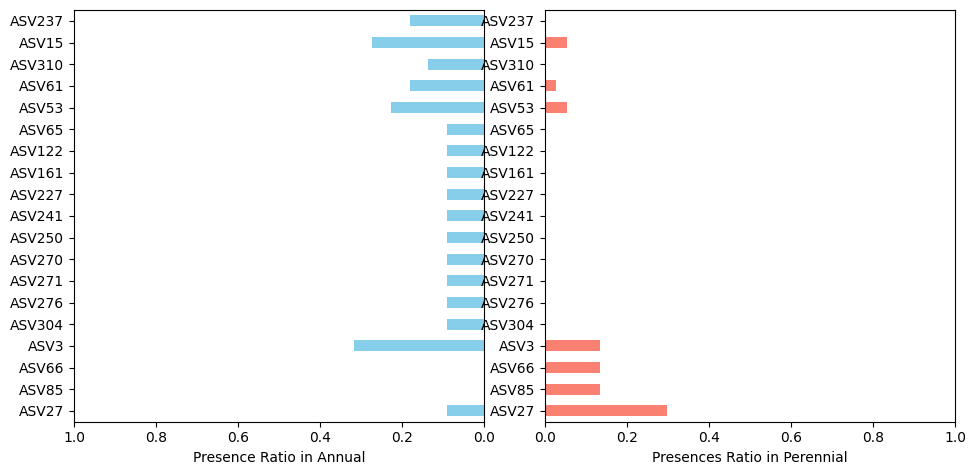

Validation passed: Dimensions are correct.
22 37
      OTU  presence_pos  presence_neg
0   ASV15      0.272727      0.054054
1   ASV61      0.181818      0.027027
2  ASV250      0.090909      0.000000
3  ASV270      0.090909      0.000000
4  ASV271      0.090909      0.000000
5  ASV276      0.090909      0.000000
6  ASV310      0.136364      0.000000


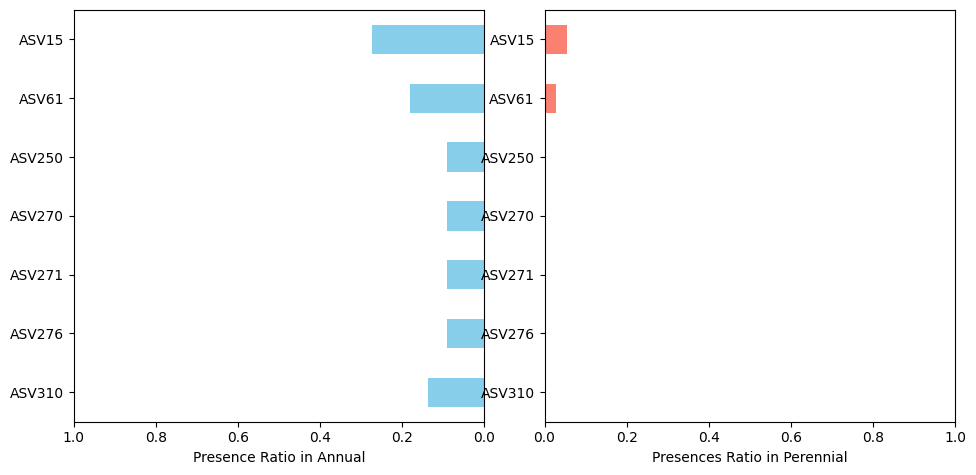

In [65]:
targetLabel=duration_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[2]],yList[:,2],selectedASVs_list[2],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_lassoft_list[2],yList[:,2],ASVs[selectedOTU_index_lassoft_list[2]],
                    posLabel="Annual",posText="Annual",negText="Perennial")
